<a href="https://colab.research.google.com/github/sheepjun96/Hands_On-Maching-Learning/blob/main/copy_17_autoencoders_gans_and_diffusion_models_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**17장 – 오토인코더, GAN 그리고 확산 모델**

_이 노트북에는 17장의 모든 샘플 코드와 연습 문제에 대한 해결책이 포함되어 있습니다._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# 설정

이 프로젝트에는 Python 3.7 이상이 필요합니다:

In [ ]:
import sys

assert sys.version_info >= (3, 7)

또한 Scikit-Learn ≥ 1.0.1이 필요합니다:

In [ ]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

그리고 TensorFlow ≥ 2.8:

In [ ]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

이전 챕터에서 했던 것처럼 기본 글꼴 크기를 정의하여 그림을 더 예쁘게 만들어 보겠습니다:

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

그리고 `images/generative` 폴더를 만들고(아직 존재하지 않는 경우), 이 노트북을 통해 책에 사용할 그림을 고해상도로 저장하는 데 사용되는 `save_fig()` 함수를 정의해 보겠습니다:

In [ ]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

이 챕터는 GPU가 없으면 매우 느려질 수 있으므로 GPU가 있는지 확인하거나 그렇지 않으면 경고를 표시합니다:

In [ ]:
if not tf.config.list_physical_devices('GPU'):
    print("GPU가 감지되지 않았습니다. 신경망은 GPU가 없으면 매우 느릴 수 있습니다.")
    if "google.colab" in sys.modules:
        print("런타임 > 런타임 유형 변경으로 이동하여 하드웨어 가속기로 GPU를 선택합니다.")

# 과소완전 선형 오토인코더로 PCA 수행하기

오토인코더를 만들어 보죠.

In [ ]:
import tensorflow as tf

tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse", optimizer=optimizer)

이제 8장에서 사용한 것과 동일한 3D 데이터셋을 생성해 보겠습니다:

In [ ]:
# 추가 코드 - 8장에서와 동일한 3D 데이터셋을 만듭니다.

import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # 3D 데이터 세트 초기화
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # 고르지 않은 분포
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # 타원형
X += 0.28 * np.random.randn(m, 3)  # 노이즈 추가
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # 약간 이동

In [ ]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 9ms/step


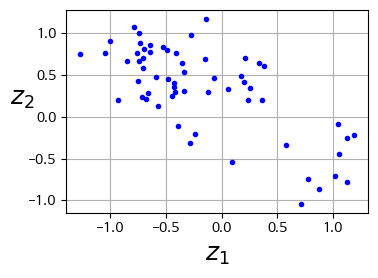

In [ ]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# 적층 오토인코더

## 케라스를 사용하여 적층 오토인코더 구현하기

패션 MNIST 데이터셋을 로드하고 크기를 조정한 다음 훈련 세트, 검증 세트, 테스트 세트로 분할해 보겠습니다:

In [ ]:
# 추가 코드 - 패션 MNIST 데이터셋 로드, 스케일링 및 분할
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

3개의 은닉 층과 1개의 출력 층으로 구성된 적층 오토인코더를 만들고 훈련해 보겠습니다.

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

# Epoch 20/20
# 1719/1719 [==============================] - 7s 4ms/step - loss: 0.0139 - val_loss: 0.0143

## 재구성 시각화하기

이 함수는 몇 가지 검증 이미지를 오토인코더에 통과시키고 원본 이미지와 재구성된 이미지를 표시합니다:

1/1 [==============================] - 0s 69ms/step


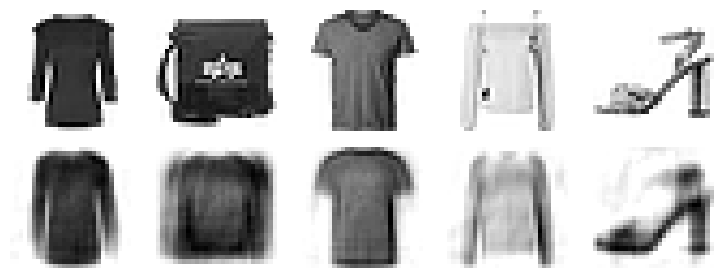

In [ ]:
import numpy as np

def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

plot_reconstructions(stacked_ae)
save_fig("reconstruction_plot")  # 추가 코드 - 고해상도 그림 저장
plt.show()

재구성된 이미지가 흐릿해 보이지만 784개가 아닌 30개의 숫자로 압축되었다는 점을 기억하세요.

## 패션 MNIST 데이터셋 시각화하기

In [ ]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 2ms/step


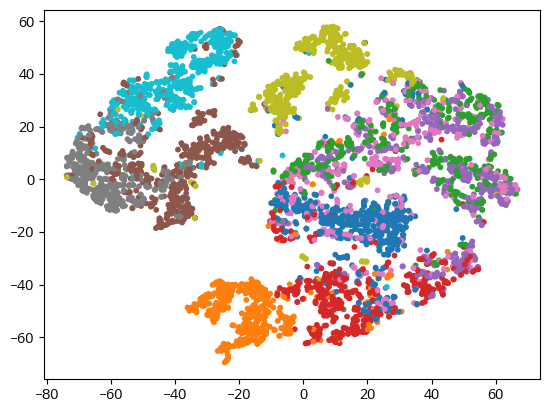

In [ ]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

이 다이어그램을 좀 더 예쁘게 만들어 봅시다([이 Scikit-Learn 예제](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html)를 참고했습니다):

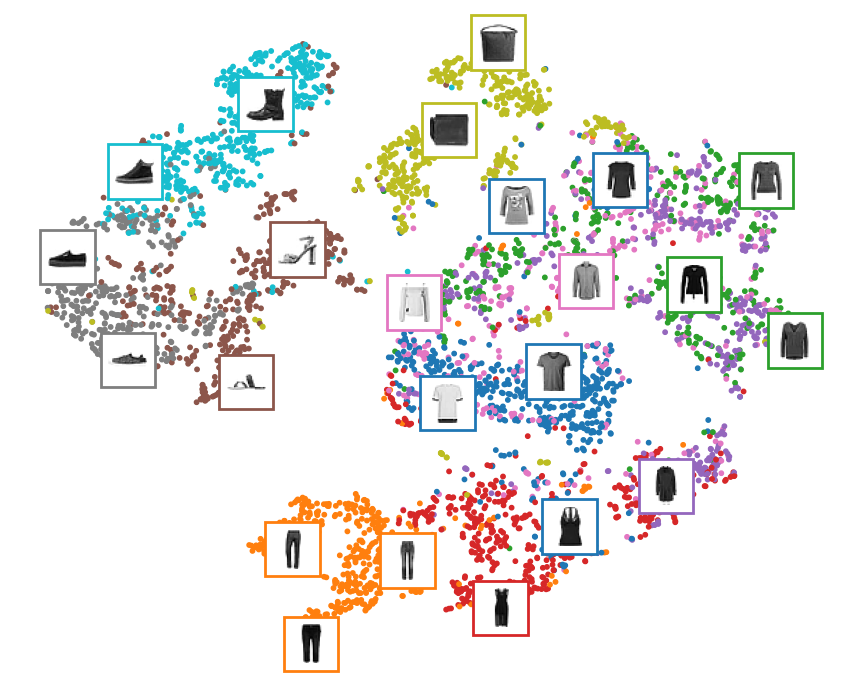

In [ ]:
# 추가 코드 - 이전 그래프를 아름답게 꾸밉니다.

import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # 0-1 범위로 정규화
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # 다른 이미지와 충분히 멀리 떨어져 있는 경우
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## 가중치 묶기

인코더 가중치의 전치를 디코더 가중치로 사용하여 인코더와 디코더의 가중치를 묶는 것이 일반적입니다. 이를 위해서는 사용자 정의 층을 사용해야 합니다.

In [ ]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=self.dense.input_shape[-1],
                                      initializer="zeros")
        super().build(batch_input_shape)

    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([28, 28])
])

tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])

# 추가 코드 - 모델을 컴파일하고 훈련합니다.
tied_ae.compile(loss="mse", optimizer="nadam")
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

# Epoch 10/10
# 1719/1719 [==============================] - 6s 4ms/step - loss: 0.0135 - val_loss: 0.0136

1/1 [==============================] - 0s 64ms/step


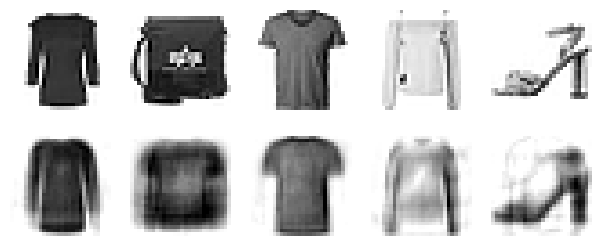

In [ ]:
# 추가 코드 - 플롯 재구성
plot_reconstructions(tied_ae)
plt.show()

## 추가 자료 - 한 번에 하나씩 오토인코더 훈련하기

In [ ]:
def train_autoencoder(n_neurons, X_train, X_valid, n_epochs=10,
                      output_activation=None):
    n_inputs = X_train.shape[-1]
    encoder = tf.keras.layers.Dense(n_neurons, activation="relu")
    decoder = tf.keras.layers.Dense(n_inputs, activation=output_activation)
    autoencoder = tf.keras.Sequential([encoder, decoder])
    autoencoder.compile(loss="mse", optimizer="nadam")
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [ ]:
tf.random.set_seed(42)

X_train_flat = tf.keras.layers.Flatten()(X_train)
X_valid_flat = tf.keras.layers.Flatten()(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat)
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, output_activation="relu")

# Epoch 10/10
# 1719/1719 [==============================] - 5s 3ms/step - loss: 0.0292 - val_loss: 0.0294

In [ ]:
stacked_ae_1_by_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    enc1, enc2, dec2, dec1,
    tf.keras.layers.Reshape([28, 28])
])

1/1 [==============================] - 0s 95ms/step


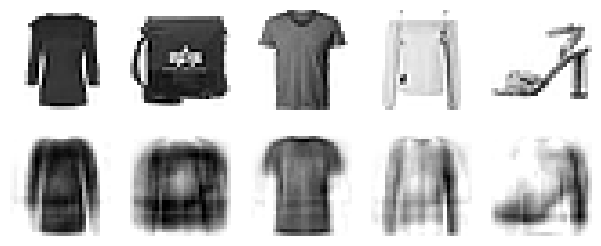

In [ ]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

필요한 경우 전체 적층 오토인코더를 몇 에포크 동안 계속 학습할 수 있습니다:

In [ ]:
stacked_ae_1_by_1.compile(loss="mse", optimizer="nadam")
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=5,
                                validation_data=(X_valid, X_valid))

# Epoch 5/5
# 1719/1719 [==============================] - 8s 4ms/step - loss: 0.0134 - val_loss: 0.0135

1/1 [==============================] - 0s 77ms/step


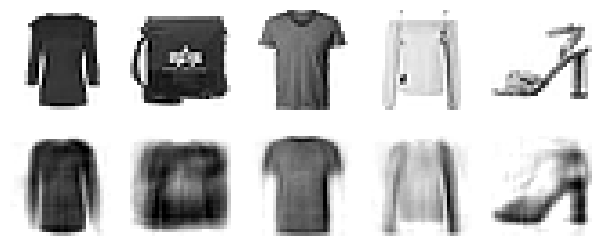

In [ ]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

## 합성곱 오토인코더

3개의 은닉 층과 1개의 출력 층으로 구성된 적층 오토인코더를 만들어 보겠습니다.

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # 출력: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # 출력: 7 × 7 x 32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # 출력: 3 × 3 x 64
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D()  # 출력: 30
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same",
                                    activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28])
])
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

# 추가 코드 - 모델을 컴파일하고 훈련합니다.
conv_ae.compile(loss="mse", optimizer="nadam")
history = conv_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

# Epoch 10/10
# 1719/1719 [==============================] - 13s 8ms/step - loss: 0.0128 - val_loss: 0.0135

1/1 [==============================] - 0s 392ms/step


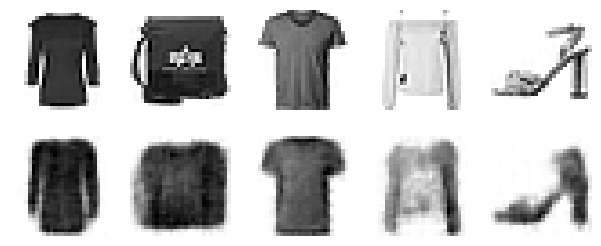

In [ ]:
# 추가 코드 - 재구성을 표시합니다.
plot_reconstructions(conv_ae)
plt.show()

# 추가 자료 - 순환 오토인코더

각 패션 MNIST 이미지를 각각 28개의 차원을 가진 28개의 벡터 시퀀스로 취급해 보겠습니다:

In [ ]:
tf.random.set_seed(42)

recurrent_encoder = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(30)
])
recurrent_decoder = tf.keras.Sequential([
    tf.keras.layers.RepeatVector(28),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dense(28)
])
recurrent_ae = tf.keras.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="mse", optimizer="nadam")

In [ ]:
history = recurrent_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

# Epoch 10/10
#1719/1719 [==============================] - 19s 11ms/step - loss: 0.0107 - val_loss: 0.0107

1/1 [==============================] - 1s 997ms/step


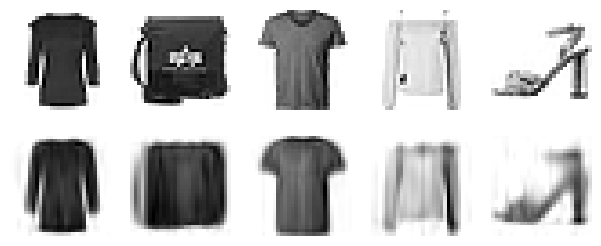

In [ ]:
plot_reconstructions(recurrent_ae)
plt.show()

# 잡음 제거 오토인코더

드롭아웃 사용:

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

# 추가 코드 - 모델을 컴파일하고 훈련합니다.
dropout_ae.compile(loss="mse", optimizer="nadam")
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

# Epoch 10/10
# 1719/1719 [==============================] - 8s 5ms/step - loss: 0.0183 - val_loss: 0.0164

1/1 [==============================] - 0s 72ms/step


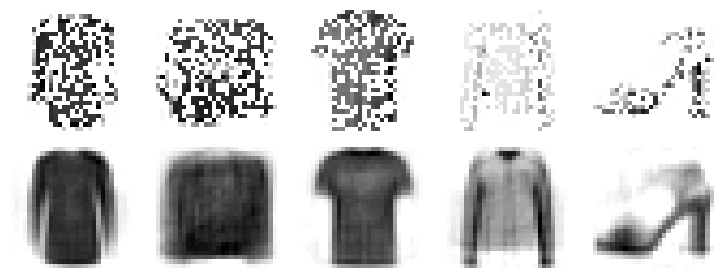

In [ ]:
# 추가 코드 - 이 셀은 그림 17-9를 생성하고 저장합니다.
tf.random.set_seed(42)
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot")
plt.show()

원하는 경우 `Dropout` 레이어를 `tf.keras.layers.GaussianNoise(0.2)`로 교체해 볼 수 있습니다.

# 희소 오토인코더

코딩 레이어에서 시그모이드 활성화 함수를 사용해 보겠습니다. 여기에 $\ell_1$ 정규화도 추가해 보겠습니다: 이를 위해 코딩 층 뒤에 `ActivityRegularization` 층을 추가합니다. 또는 코딩 층 자체에 `activity_regularizer=tf.keras.regularizers.l1(1e-4)`를 추가할 수도 있습니다.

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid"),
    tf.keras.layers.ActivityRegularization(l1=1e-4)
])
sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_l1_ae = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])

# 추가 코드 - 모델을 컴파일하고 훈련합니다.
sparse_l1_ae.compile(loss="mse", optimizer="nadam")
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

# Epoch 10/10
# 1719/1719 [==============================] - 8s 5ms/step - loss: 0.0111 - val_loss: 0.0113

1/1 [==============================] - 0s 73ms/step


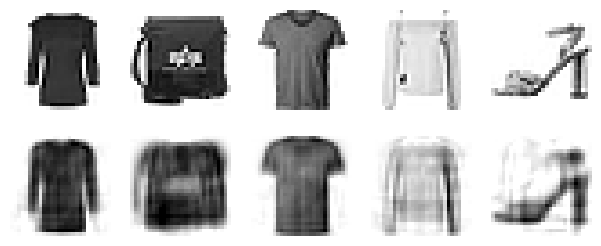

In [ ]:
# 추가 코드 - 재구성을 표시합니다.
plot_reconstructions(sparse_l1_ae)
plt.show()

KL 발산 손실과 MAE 및 MSE를 비교하여 그래프를 그려 보겠습니다:

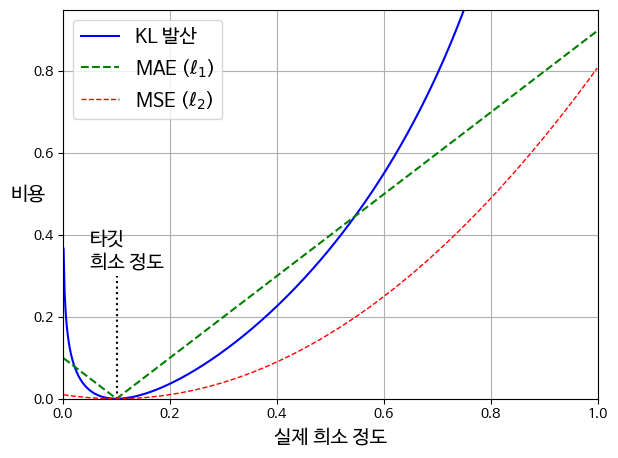

In [ ]:
# 추가 코드 - 이 셀은 그림 17-10을 생성하고 저장합니다.
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q) ** 2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "타깃\n희소 정도", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL 발산")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("실제 희소 정도")
plt.ylabel("비용", rotation=0)
plt.axis([0, 1, 0, 0.95])
plt.grid(True)
save_fig("sparsity_loss_plot")

KL-발산 규제를 위한 사용자 정의 클래스를 정의해 보겠습니다:

In [ ]:
kl_divergence = tf.keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight, target):
        self.weight = weight
        self.target = target

    def __call__(self, inputs):
        mean_activities = tf.reduce_mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

이제 이 규제를 사용하여 코딩 층에서 모델의 희소 정도가 약 10%가 되도록 해 보겠습니다:

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

kld_reg = KLDivergenceRegularizer(weight=5e-3, target=0.1)
sparse_kl_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid",
                          activity_regularizer=kld_reg)
])
sparse_kl_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_kl_ae = tf.keras.Sequential([sparse_kl_encoder, sparse_kl_decoder])

# 추가 코드 - 모델을 컴파일하고 훈련합니다.
sparse_kl_ae.compile(loss="mse", optimizer="nadam")
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

# Epoch 10/10
# 1719/1719 [==============================] - 9s 5ms/step - loss: 0.0095 - val_loss: 0.0095

1/1 [==============================] - 0s 98ms/step


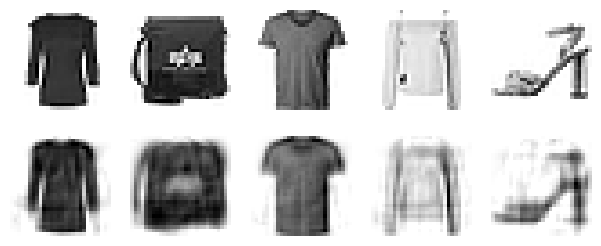

In [ ]:
# 추가 코드 - 재구성을 표시합니다.
plot_reconstructions(sparse_kl_ae)
plt.show()

# 변이형 오토인코더

In [ ]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

codings_size = 10

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [ ]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [ ]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [ ]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [ ]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

# Epoch 25/25
# 430/430 [==============================] - 3s 7ms/step - loss: 0.0308 - val_loss: 0.0310

1/1 [==============================] - 0s 127ms/step


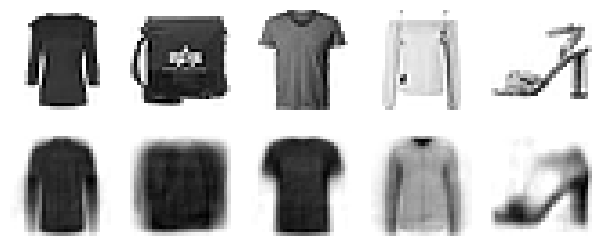

In [ ]:
plot_reconstructions(variational_ae)
plt.show()

## 패션 이미지 생성

몇 가지 무작위 코딩을 생성하고 디코딩해 보겠습니다:

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

이제 이 이미지를 출력해 보겠습니다:

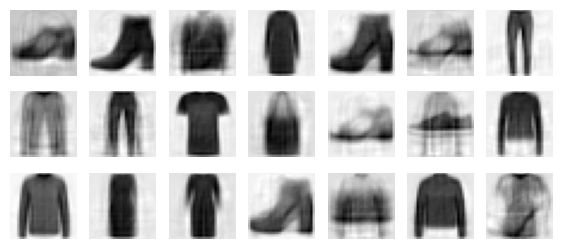

In [ ]:
# 추가 코드 - 이 셀은 그림 17-12를 생성하고 저장합니다.

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
save_fig("vae_generated_images_plot", tight_layout=False)
plt.show()

이제 두 이미지 사이에 시맨틱 보간을 수행해 보겠습니다:

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

codings = np.zeros([7, codings_size])
codings[:, 3] = np.linspace(-0.8, 0.8, 7)  # 이 경우 축 3이 가장 좋습니다.
images = variational_decoder(codings).numpy()

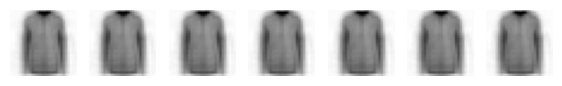

In [ ]:
# 추가 코드 - 이 셀은 그림 17-13을 생성하고 저장합니다.
plot_multiple_images(images)
save_fig("semantic_interpolation_plot", tight_layout=False)
plt.show()

# 생성적 적대 신경망

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

codings_size = 30

Dense = tf.keras.layers.Dense
generator = tf.keras.Sequential([
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(28 * 28, activation="sigmoid"),
    tf.keras.layers.Reshape([28, 28])
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

에포크 1/10


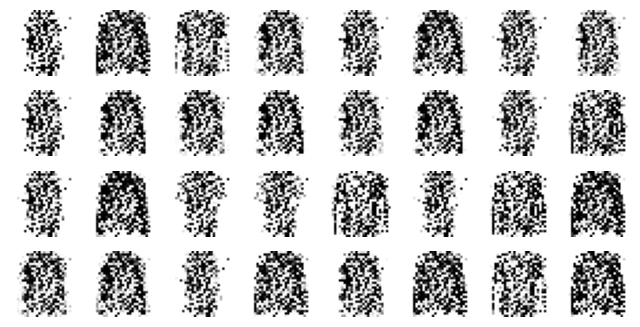

에포크 2/10


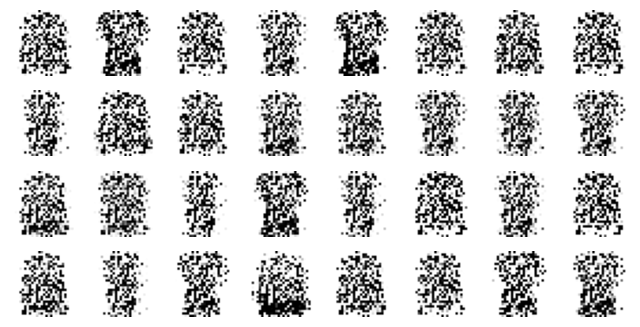

에포크 3/10


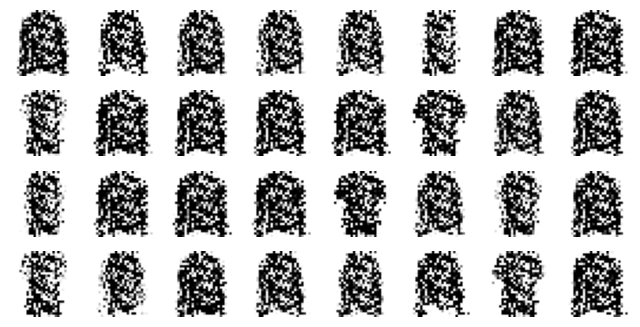

에포크 4/10


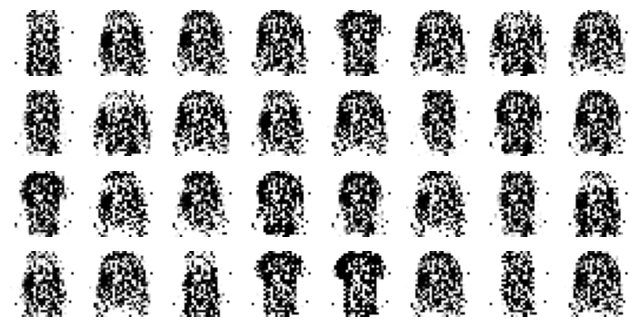

에포크 5/10


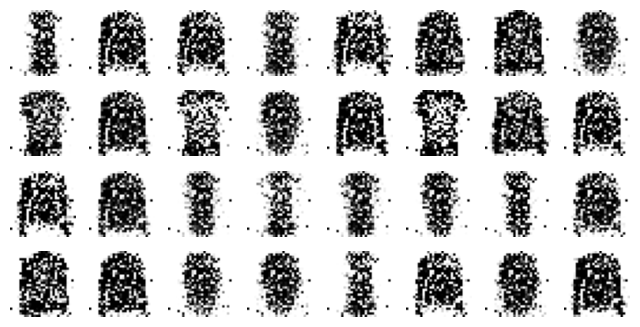

에포크 6/10


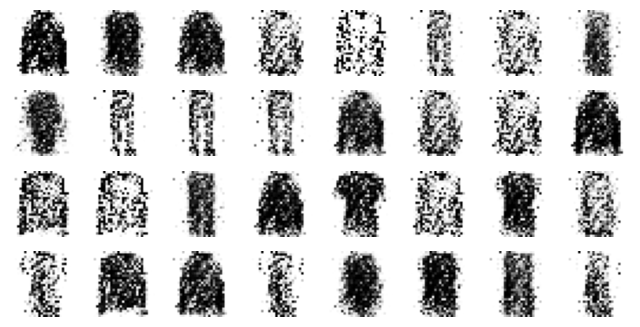

에포크 7/10


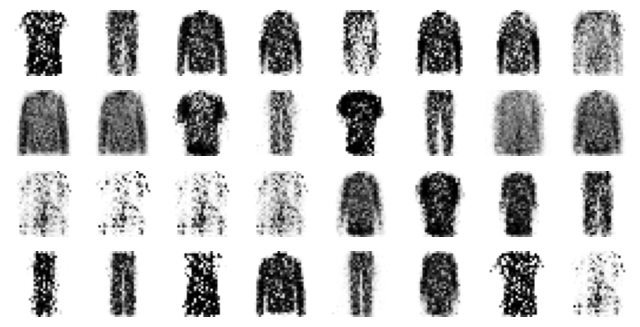

에포크 8/10


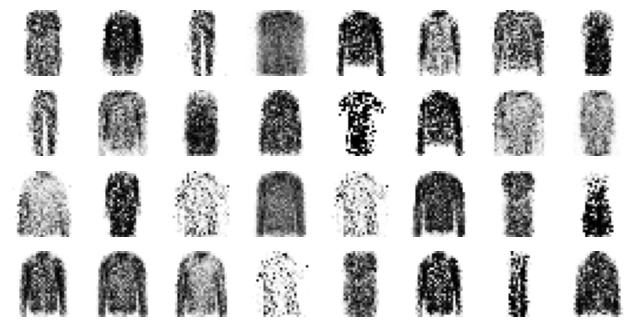

에포크 9/10


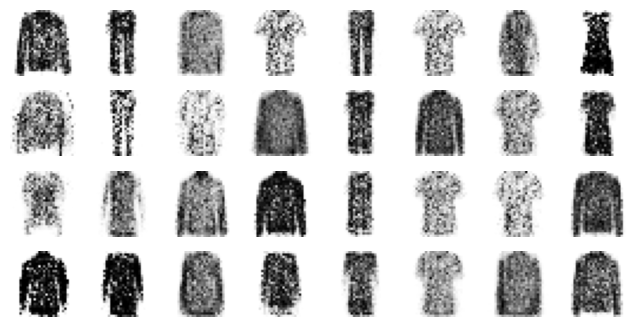

에포크 10/10


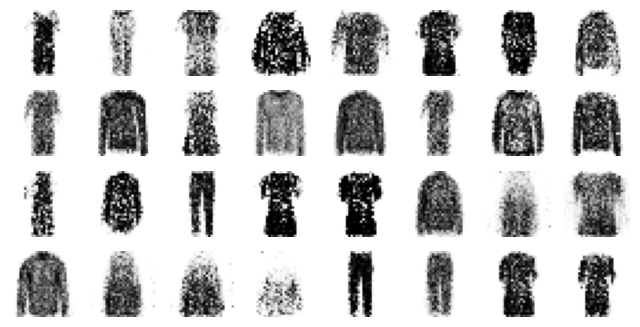

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"에포크 {epoch + 1}/{n_epochs}")  # 추가 코드
        for X_batch in dataset:
            # 1단계 - 판별자 훈련
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)
            # 2단계 - 생성자 훈련
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)
        # 추가 코드 - 훈련 중 이미지 출력
        plot_multiple_images(generated_images.numpy(), 8)
        plt.show()

# 코랩에서 메모리 부족 에러를 피하기 위해 n_epochs를 50에서 10으로 바꿉니다.
train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

codings = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(codings)

1/1 [==============================] - 0s 63ms/step


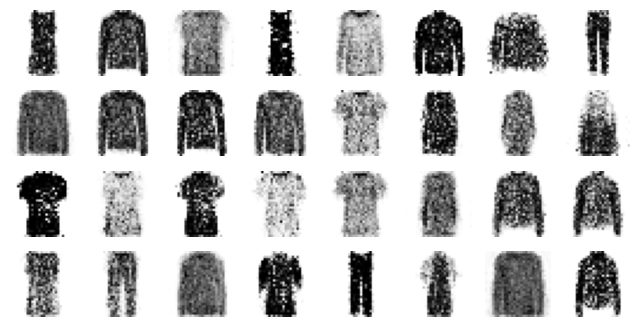

In [ ]:
# 추가 코드 - 이 셀은 그림 17-15를 생성하고 저장합니다.
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)
plt.show()

# 심층 합성곱 GAN

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

codings_size = 100

generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2,
                                    padding="same", activation="tanh"),
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

In [ ]:
# 추가 코드 - 앞서와 같이 판별자와 gan을 컴파일합니다.
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # 크기 변경 및 스케일 조정

에포크 1/10


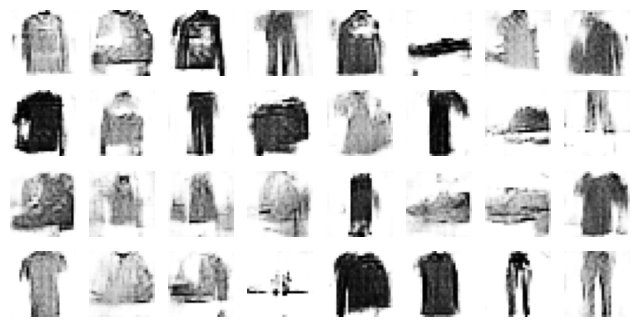

에포크 2/10


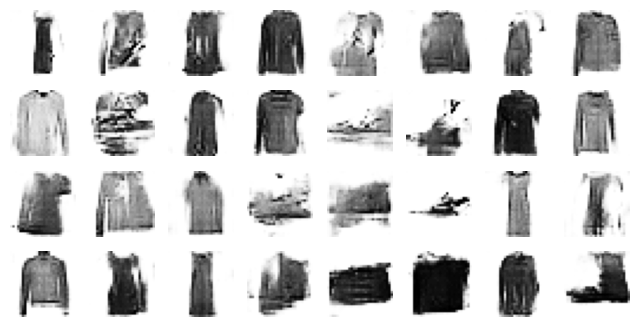

에포크 3/10


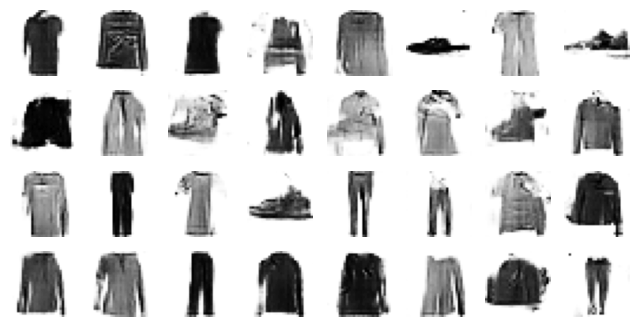

에포크 4/10


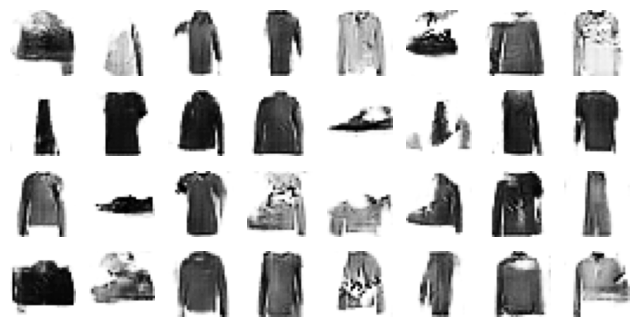

에포크 5/10


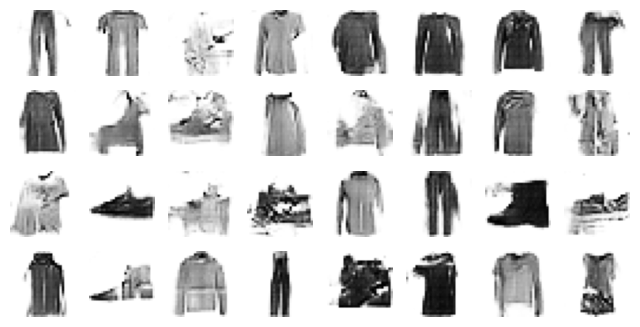

에포크 6/10


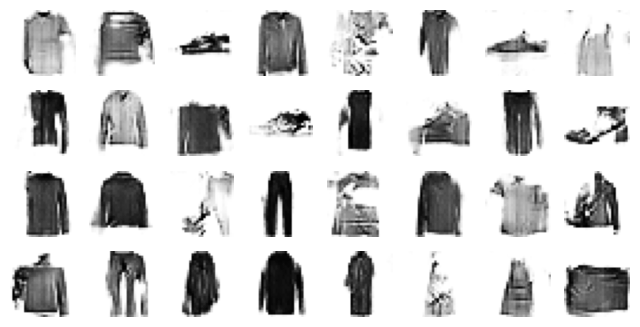

에포크 7/10


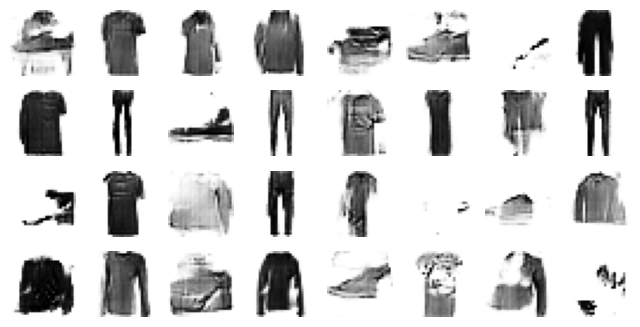

에포크 8/10


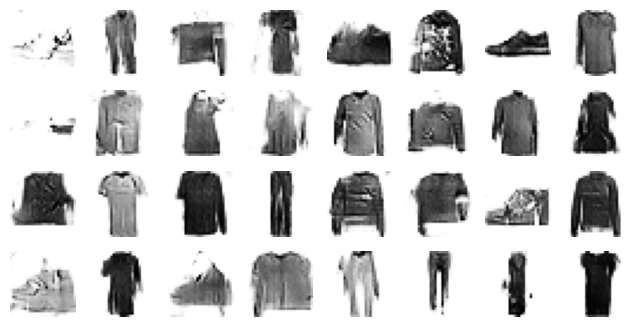

에포크 9/10


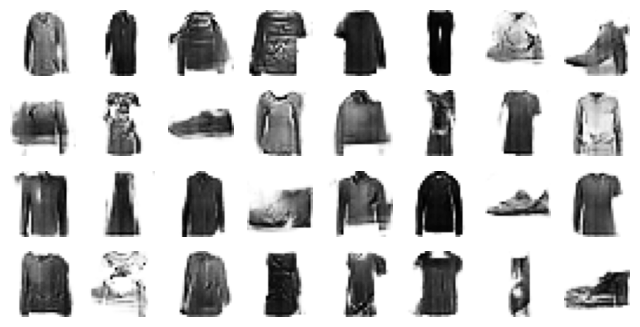

에포크 10/10


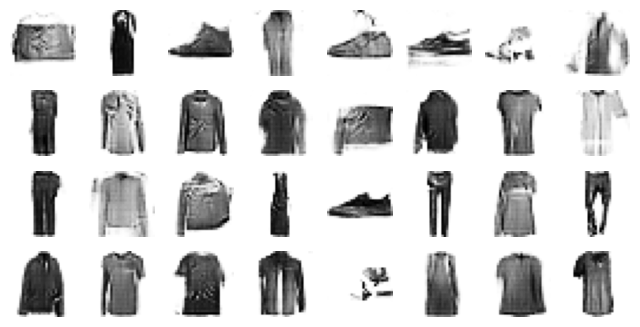

In [ ]:
# 추가 코드 - 앞서와 마찬가지로 데이터셋을 생성하고 GAN을 학습시킵니다.
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
# 코랩에서 메모리 부족 에러를 피하기 위해 n_epochs를 50에서 10으로 바꿉니다.
train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)

1/1 [==============================] - 0s 105ms/step


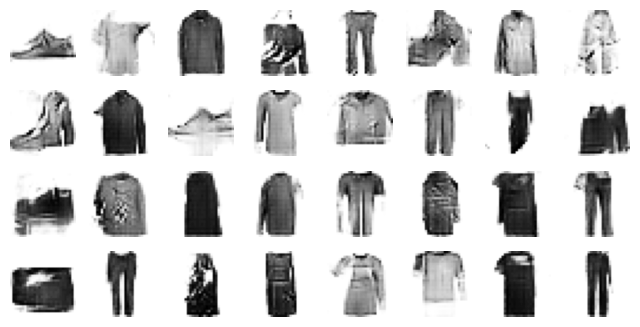

In [ ]:
# 추가 코드 - 이 셀은 그림 17-16을 생성하고 저장합니다.
tf.random.set_seed(42)
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)

# 확산 모델

데이터셋의 이미지로 시작하여 각 타임 스텝 $t$에서 확산 과정은 평균 0, 분산 $\beta_t$의 가우스 잡음을 추가합니다. 그런 다음 모델은 이 프로세스를 역으로 수행하도록 훈련됩니다. 보다 구체적으로, 정방향 과정에 의해 생성된 잡음 이미지와 시간 $t$가 주어지면 모델은 분산 1로 스케일링된 원본 이미지에 추가된 총 잡음을 예측하도록 훈련됩니다.

[DDPM 논문](https://arxiv.org/abs/2006.11239)에서는 $\beta_1$ = 0.0001에서 $\beta_T = $0.02($T$가 최대 스텝)로 $\beta_t$를 늘렸지만, [개선된 DDPM 논문](https://arxiv.org/pdf/2102.09672.pdf)에서는 $\bar{\alpha_t} = \prod_{i=0}^{t}$를 점차적으로 감소시키는 다음과 같은 $\cos^2(\ldots)$ 스케줄 사용을 제안했습니다. $\alpha_i$ 를 1에서 0으로, 여기서 $\alpha_t = 1 - \beta_t$ 로 점차 감소시킵니다:

In [ ]:
def variance_schedule(T, s=0.008, max_beta=0.999):
    t = np.arange(T + 1)
    f = np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2
    alpha = np.clip(f[1:] / f[:-1], 1 - max_beta, 1)
    alpha = np.append(1, alpha).astype(np.float32)  # add α₀ = 1
    beta = 1 - alpha
    alpha_cumprod = np.cumprod(alpha)
    return alpha, alpha_cumprod, beta  # αₜ , α̅ₜ , βₜ for t = 0 to T

np.random.seed(42)  # 추가 코드 - 재현성을 위한
T = 4000
alpha, alpha_cumprod, beta = variance_schedule(T)

DDPM 논문에서 저자들은 $T = 1,000$을 사용했지만, 개선된 DDPM에서는 이 값을 $T = 4,000$으로 늘렸기 때문에 이 값을 사용합니다. `alpha` 변수는 $\alpha_0, \alpha_1, ..., \alpha_T$를 포함하는 벡터입니다. 변수 `alpha_cumprod`는 $\bar{\alpha_0}, \bar{\alpha_1}, ..., \bar{\alpha_T}$를 포함하는 벡터입니다.

`alpha_cumprod`을 그래프로 그려보죠:

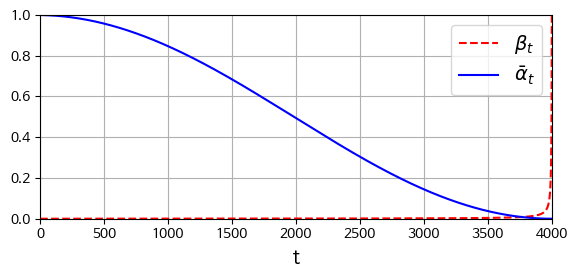

In [ ]:
# 추가 코드 - 이 셀은 그림 17-21을 생성하고 저장합니다.
plt.figure(figsize=(6, 3))
plt.plot(beta, "r--", label=r"$\beta_t$")
plt.plot(alpha_cumprod, "b", label=r"$\bar{\alpha}_t$")
plt.axis([0, T, 0, 1])
plt.grid(True)
plt.xlabel(r"t")
plt.legend()
save_fig("variance_schedule_plot")
plt.show()

`prepare_batch()` 함수는 이미지 배치를 가져와 각 이미지에 대해 1에서 $T$ 사이의 다른 임의 시간을 사용하여 각 이미지에 잡음을 추가하고 입력과 타겟을 포함하는 튜플을 반환합니다:

* 입력은 잡음이 있는 이미지와 해당 시간이 포함된 `dict`입니다. 이 함수는 DDPM 논문의 방정식 (4)를 사용하여 원본 이미지에서 직접 노이즈가 있는 이미지를 한 번에 계산합니다. 이는 정방향 확산 과정의 지름길입니다.
* 타깃은 잡음 이미지를 생성하는 데 사용된 잡음입니다.

In [ ]:
def prepare_batch(X):
    X = tf.cast(X[..., tf.newaxis], tf.float32) * 2 - 1  # -1에서 +1까지 스케일링
    X_shape = tf.shape(X)
    t = tf.random.uniform([X_shape[0]], minval=1, maxval=T + 1, dtype=tf.int32)
    alpha_cm = tf.gather(alpha_cumprod, t)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    noise = tf.random.normal(X_shape)
    return {
        "X_noisy": alpha_cm ** 0.5 * X + (1 - alpha_cm) ** 0.5 * noise,
        "time": t,
    }, noise

이제 훈련과 검증을 위한 `tf.data.Dataset`을 준비합니다.

In [ ]:
def prepare_dataset(X, batch_size=32, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(X)
    if shuffle:
        ds = ds.shuffle(10_000)
    return ds.batch(batch_size).map(prepare_batch).prefetch(1)

tf.random.set_seed(43)  # 추가 코드 - CPU에서 재현성 보장
train_set = prepare_dataset(X_train, batch_size=32, shuffle=True)
valid_set = prepare_dataset(X_valid, batch_size=32)

간단한 모델 상태를 확인하기 위해 몇 가지 훈련 샘플과 예측할 잡음, 원본 이미지(적절하게 스케일링된 잡음 이미지에서 적절하게 스케일링된 잡음을 빼서 얻은 이미지)를 살펴 보겠습니다:

원본 이미지


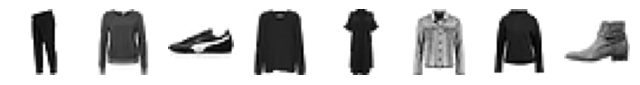

타임 스텝: [3405  312 3441 1991 2443 1657 3308 1151]
잡음 이미지


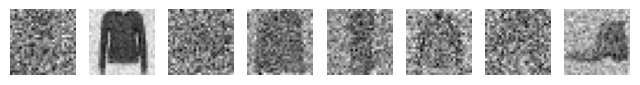

예측할 잡음


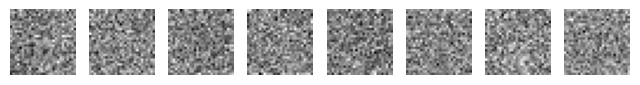

In [ ]:
# 추가 코드 - 간단한 데이터 검증

def subtract_noise(X_noisy, time, noise):
    X_shape = tf.shape(X_noisy)
    alpha_cm = tf.gather(alpha_cumprod, time)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    return (X_noisy - (1 - alpha_cm) ** 0.5 * noise) / alpha_cm ** 0.5

X_dict, Y_noise = list(train_set.take(1))[0]  # get the first batch
X_original = subtract_noise(X_dict["X_noisy"], X_dict["time"], Y_noise)

print("원본 이미지")
plot_multiple_images(X_original[:8].numpy())
plt.show()
print("타임 스텝:", X_dict["time"].numpy()[:8])
print("잡음 이미지")
plot_multiple_images(X_dict["X_noisy"][:8].numpy())
plt.show()
print("예측할 잡음")
plot_multiple_images(Y_noise[:8].numpy())
plt.show()

이제 확산 모델 자체를 구축할 준비가 되었습니다. 이미지와 시간을 모두 처리해야 합니다. DDPM 논문에서 제안한 대로 [트랜스포머](https://arxiv.org/abs/1706.03762) 논문에서처럼 사인파 인코딩을 사용하여 시간을 인코딩합니다. 시간 인덱스(정수)를 나타내는 _m_ 정수의 벡터가 주어지면 이 층은 _m_ × _d_ 행렬을 반환하며, 여기서 _d_는 선택한 임베딩 크기입니다.

In [ ]:
# 추가 코드 - 사용자 정의 시간 인코딩 층을 구현합니다.

embed_size = 64

class TimeEncoding(tf.keras.layers.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))
        t_emb = np.empty((T + 1, embed_size))
        t_emb[:, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        t_emb[:, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.time_encodings = tf.constant(t_emb.astype(self.dtype))

    def call(self, inputs):
        return tf.gather(self.time_encodings, inputs)

이제 모델을 빌드해 보겠습니다. 개선된 DDPM 문서에서는 UNet 모델을 사용합니다. `Conv2D` + `BatchNormalization` 층을 통해 이미지를 처리하고 스킵 연결을 가진 UNet과 유사한 모델을 만들어 보겠습니다. 점차적으로 이미지 다운샘플링(`strides=2`인 `MaxPooling` 층을 사용)한 다음 다시 업샘플링합니다(`Upsampling2D` 층 사용). 다운샘플링 부분과 업샘플링 부분에 스킵 연결이 추가됩니다. 또한 `Dense` 레이어를 통과하여 올바른 크기로 크기를 조정한 후 각 블록의 출력에 시간 인코딩을 추가합니다.

* **참고**: 이미지의 시간 인코딩은 마지막 축(채널)을 따라 이미지의 모든 픽셀에 추가됩니다. 따라서 `Conv2D` 층의 유닛 수는 임베딩 크기와 일치해야 하며, `time_enc` 텐서를 재구성하여 너비 및 높이 차원을 추가해야 합니다.
* 이 UNet 구현은 keras.io의 [이미지 분할 예제](https://keras.io/examples/vision/oxford_pets_image_segmentation/)와 [공식 확산 모델 구현](https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/models/unet.py)을 참고했습니다. 첫 번째 구현과 비교하여 몇 가지를 추가했는데, 특히 시간 인코딩과 다운/업 부분의 스킵 연결이 추가되었습니다. 두 번째 구현과 비교하여 몇 가지 사항, 특히 주의 레이어를 제거했습니다. 패션 MNIST에는 과한 것 같지만 자유롭게 추가할 수 있습니다.

In [ ]:
def build_diffusion_model():
    X_noisy = tf.keras.layers.Input(shape=[28, 28, 1], name="X_noisy")
    time_input = tf.keras.layers.Input(shape=[], dtype=tf.int32, name="time")
    time_enc = TimeEncoding(T, embed_size)(time_input)

    dim = 16
    Z = tf.keras.layers.ZeroPadding2D((3, 3))(X_noisy)
    Z = tf.keras.layers.Conv2D(dim, 3)(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)
    Z = tf.keras.layers.Activation("relu")(Z)

    time = tf.keras.layers.Dense(dim)(time_enc)  # 시간 인코딩 적용
    Z = time[:, tf.newaxis, tf.newaxis, :] + Z  # 모든 픽셀에 시간 데이터 추가

    skip = Z
    cross_skips = []  # UNet의 다운샘플링 & 업샘플링을 가로지르는 스킵 연결

    for dim in (32, 64, 128):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        cross_skips.append(Z)
        Z = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(Z)
        skip_link = tf.keras.layers.Conv2D(dim, 1, strides=2,
                                           padding="same")(skip)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        skip = Z

    for dim in (64, 32, 16):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.UpSampling2D(2)(Z)

        skip_link = tf.keras.layers.UpSampling2D(2)(skip)
        skip_link = tf.keras.layers.Conv2D(dim, 1, padding="same")(skip_link)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        Z = tf.keras.layers.concatenate([Z, cross_skips.pop()], axis=-1)
        skip = Z

    outputs = tf.keras.layers.Conv2D(1, 3, padding="same")(Z)[:, 2:-2, 2:-2]
    return tf.keras.Model(inputs=[X_noisy, time_input], outputs=[outputs])

모델을 훈련시켜 봅시다!

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장
model = build_diffusion_model()
model.compile(loss=tf.keras.losses.Huber(), optimizer="nadam")

# 추가 코드 - 모델 체크포인트 콜백을 추가합니다.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_diffusion_model",
                                                   save_best_only=True)

history = model.fit(train_set, validation_data=valid_set, epochs=100,
                    callbacks=[checkpoint_cb])  # 추가 코드

# Epoch 100/100
# 1719/1719 [==============================] - 54s 32ms/step - loss: 0.0381 - val_loss: 0.0374

모델이 훈련되면 이를 사용하여 새 이미지를 생성할 수 있습니다. 이를 위해 가우스 잡음을 생성하고 이것이 시간 $T$ 동안의 확산 과정의 결과라고 가정합니다. 그런 다음 모델을 사용하여 $T - 1$ 시점의 이미지를 예측한 다음 다시 호출하여 $T - 2$를 구하는 식으로 각 단계에서 약간의 노이즈를 제거합니다. 마지막으로 패션 MNIST 데이터셋에서 가져온 것처럼 보이는 이미지를 얻습니다. 이 역방향 과정에 대한 방정식은 DDPM 논문 4페이지 상단에 있습니다(알고리즘 2의 4단계).

In [ ]:
def generate(model, batch_size=32):
    X = tf.random.normal([batch_size, 28, 28, 1])
    for t in range(T - 1, 0, -1):
        print(f"\rt = {t}", end=" ")  # 추가 코드 - 진행률 표시
        noise = (tf.random.normal if t > 1 else tf.zeros)(tf.shape(X))
        X_noise = model({"X_noisy": X, "time": tf.constant([t] * batch_size)})
        X = (
            1 / alpha[t] ** 0.5
            * (X - beta[t] / (1 - alpha_cumprod[t]) ** 0.5 * X_noise)
            + (1 - alpha[t]) ** 0.5 * noise
        )
    return X

tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장
X_gen = generate(model)  # 생성된 이미지

t = 1 

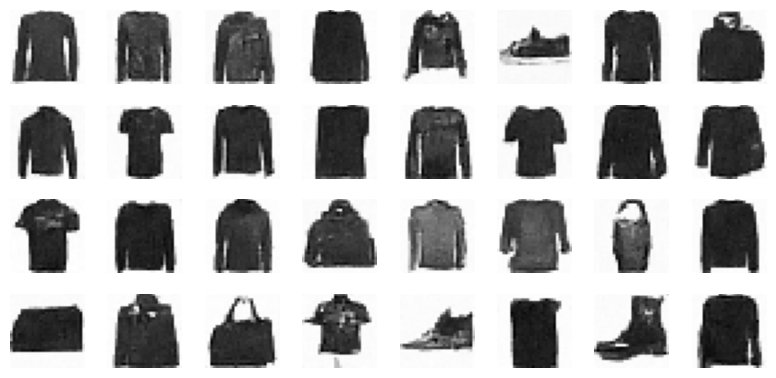

In [ ]:
plot_multiple_images(X_gen.numpy(), 8)
save_fig("ddpm_generated_images_plot")
plt.show()

이 이미지 중 일부는 정말 설득력이 있습니다! 확산 모델은 GAN에 비해 더 다양한 이미지를 생성하는 경향이 있으며, 이미지 품질에서도 GAN을 능가합니다. 또한 훈련이 훨씬 더 안정적입니다. 하지만 이미지를 생성하는 데는 시간이 훨씬 더 오래 걸립니다.

# 추가 자료 - 이진 오토인코더를 사용한 해싱

인코더에 16개의 뉴런으로 구성된 출력 층과 시그모이드 활성화 함수를 사용하고 바로 그 전에 가우스 잡음을 추가한 오토인코더를 훈련해 보겠습니다. 훈련 중에 잡음 층은 이전 층이 큰 값을 출력하도록 권장합니다. 작은 값은 잡음에 의해 희석되기 때문입니다. 그리고 시그모이드 활성화 함수 덕분에 출력 층이 0 또는 1에 가까운 값을 출력하게 됩니다. 출력 값을 0과 1로 반올림하면 16비트 "시맨틱" 해시를 얻을 수 있습니다. 모든 것이 잘 작동하면 비슷해 보이는 이미지의 해시값이 동일합니다. 이는 검색 엔진에 매우 유용할 수 있습니다: 예를 들어 이미지의 시맨틱 해시로 식별되는 서버에 각 이미지를 저장하면 유사한 이미지가 모두 같은 서버에 저장됩니다. 검색 엔진 사용자가 검색할 이미지를 제공하면 검색 엔진이 인코더를 사용하여 이미지의 해시를 계산하고 해당 해시로 식별되는 서버의 모든 이미지를 신속하게 반환합니다.

In [ ]:
tf.random.set_seed(42)

hashing_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.GaussianNoise(15.),
    tf.keras.layers.Dense(16, activation="sigmoid"),
])
hashing_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
hashing_ae = tf.keras.Sequential([hashing_encoder, hashing_decoder])
hashing_ae.compile(loss="mse", optimizer="nadam")
history = hashing_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

# Epoch 10/10
# 1719/1719 [==============================] - 8s 5ms/step - loss: 0.0329 - val_loss: 0.0348

이 오토인코더는 정보를 너무 많이 압축하여(16비트까지!) 손실이 크지만 괜찮습니다. 이미지를 완벽하게 재구성하는 것이 아니라 시맨틱 해시를 생성하는 데 사용하므로 괜찮습니다:

1/1 [==============================] - 0s 117ms/step


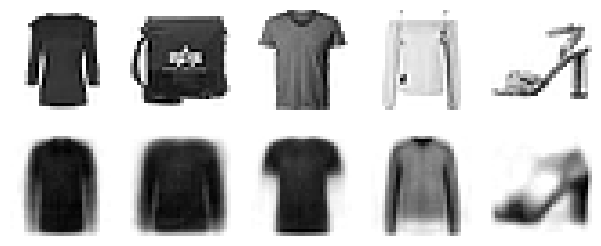

In [ ]:
plot_reconstructions(hashing_ae)
plt.show()

이제 검증 세트의 처음 몇 개의 이미지에 대한 해시가 어떻게 보이는지 살펴보겠습니다:

In [ ]:
hashes = hashing_encoder.predict(X_valid).round().astype(np.int32)
hashes *= np.array([[2 ** bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
    print(f"{h:016b}")
print("...")

157/157 [==============================] - 0s 1ms/step
1111110011110001
1111110000111001
1111110000110101
1000110011111010
1000110100001000
...


이제 유효성 검사 집합에서 가장 일반적인 이미지 해시를 찾고 각 해시에 대해 몇 개의 이미지를 표시해 보겠습니다. 다음 이미지에서는 주어진 행에 있는 모든 이미지의 해시가 동일합니다:

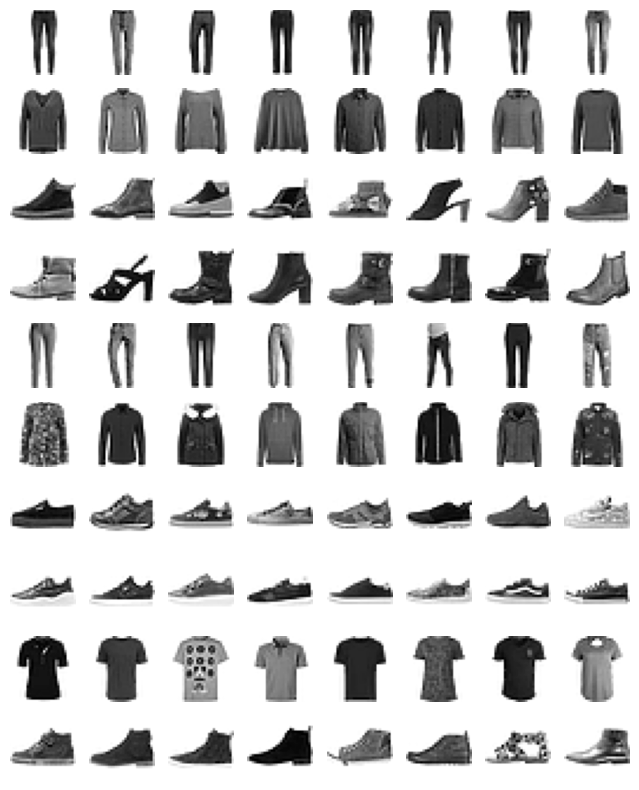

In [ ]:
from collections import Counter

n_hashes = 10
n_images = 8

top_hashes = Counter(hashes).most_common(n_hashes)

plt.figure(figsize=(n_images, n_hashes))
for hash_index, (image_hash, hash_count) in enumerate(top_hashes):
    indices = (hashes == image_hash)
    for index, image in enumerate(X_valid[indices][:n_images]):
        plt.subplot(n_hashes, n_images, hash_index * n_images + index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plt.show()

# 연습문제 해답

## 1. to 8.

부록 A 참조

## 10.
_문제: 잡음 제거 오토인코더를 사용해 이미지 분류기를 사전훈련해보세요. (간단하게) MNIST를 사용하거나 도전적인 문제를 원한다면 CIFAR10 같은 좀 더 복잡한 이미지 데이터셋을 사용할 수 있습니다. 어떤 데이터셋을 사용하던지 다음 단계를 따르세요._

* 데이터셋을 훈련 세트와 테스트 세트로 나눕니다. 전체 훈련 세트에서 심층 잡음 제거 오토인코더를 훈련합니다.
* 이미지가 잘 재구성되는 지 확인하세요. 코딩 층의 각 뉴런을 가장 크게 활성화하는 이미지를 시각화해보세요.
* 이 오토인코더의 아래 층을 재사용해 분류 DNN을 만드세요. 훈련 세트에서 이미지 500개만 사용해 훈련합니다. 사전훈련을 사용하는 것이 더 나은가요? 사용하지 않는 것이 더 나은가요?

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train / 255
X_test = X_test / 255

170498071/170498071 [==============================] - 6s 0us/step


In [ ]:
tf.random.set_seed(42)

denoising_encoder = tf.keras.Sequential([
    tf.keras.layers.GaussianNoise(0.1),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
])

In [ ]:
denoising_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(16 * 16 * 32, activation="relu"),
    tf.keras.layers.Reshape([16, 16, 32]),
    tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2,
                                 padding="same", activation="sigmoid")
])

In [ ]:
denoising_ae = tf.keras.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer="nadam",
                     metrics=["mse"])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_test, X_test))

# Epoch 10/10
# 1563/1563 [==============================] - 14s 9ms/step - loss: 0.5627 - mse: 0.0061 - val_loss: 0.5658 - val_mse: 0.0067

1/1 [==============================] - 0s 130ms/step


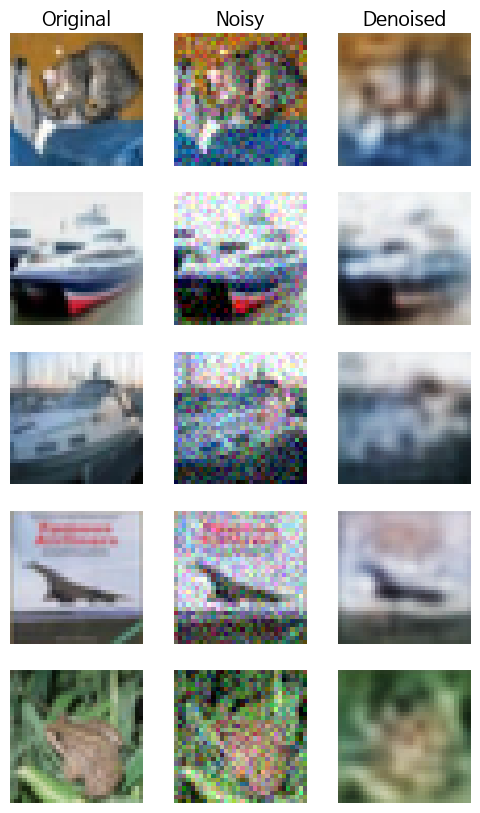

In [ ]:
n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * 0.1
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(new_images_noisy[index].clip(0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")

plt.show()

## 11.
_문제: 이미지 데이터셋을 하나 선택해 변이형 오토인코더를 훈련하고 이미지를 생성해보세요. 또는 관심있는 레이블이 없는 데이터셋을 찾아서 새로운 샘플을 생성할 수 있는지 확인해 보세요._

VAE 코드 참조

## 12.
_문제: 이미지 데이터셋을 처리하는 DCGAN을 훈련하고 이를 사용해 이미지를 생성해보세요. 경험 재생을 추가하고 도움이 되는지 확인하세요. 생성된 클래스를 제어할 수 있는 조건 GAN으로 바꾸어 시도해보세요._

TODO